<a href="https://colab.research.google.com/github/m-mehabadi/grad-maker/blob/main/_notebooks/UniversalAttackGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Areas:
* Domain Generalization in Classification
* Domain Generalization in Mitosis Detection
* Universal Adversarial Example Generator
* An Aproach to Optimize Robustness and Performance Simultaneously
* Multi-Tasking using GradMaker
* Applications in Federated Learning


In [27]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
import torch
import torch.nn as nn
import torchvision
import torchvision.datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

import gc
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm.auto import tqdm

In [29]:
# config
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Param
num_epochs = 10
num_classes = 10
batch_size = 200
learning_rate = 0.001

In [30]:
# MNIST datasets
train_dataset = torchvision.datasets.MNIST(root='./', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./', train=False, transform=transforms.ToTensor(), download=True)

# MNIST dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
# CNN(two layer)
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7 * 7 * 32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [32]:
def validate(model, dloader, pert=None, is_batched=True):
    model.eval()
    correct = 0
    total = 0
    pert_ = pert(model, dloader) if (not is_batched) and (pert is not None) else None
    for i, (images, labels) in enumerate(tqdm(dloader)):
        images = images.to(device)
        labels = labels.to(device)
        
        #
        if pert is not None:
            images = Variable(images.clone(), requires_grad=True)
            pert_ = pert(model, images, labels) if is_batched else pert_
            images = images.data.detach() + pert_.data.detach()
        #
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        #
        # print(f"Batch {i}/{len(dloader)}, processed.")

        gc_collect(pert_, images, labels, outputs, predicted, _)
        empty_cache()
    return (100 * correct / total)

In [33]:
def gc_collect(*vars):
    for var in vars:
        del var
    gc.collect()

def empty_cache():
    torch.cuda.empty_cache()

In [34]:
model = ConvNet(num_classes).to(device)

# Loss and optimize
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train
model.train()
total_step = len(train_loader)
for epoch in tqdm(range(num_epochs)):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backprop and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if (i + 1) % 100 == 0:
        #     print (f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Training Loss: {loss.item():.4f}')

# Test the model
print(f'Model Accuracy on the 10000 test images: {validate(model, test_loader):.4f} %')

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Model Accuracy on the 10000 test images: 98.5900 %


### Now let's generate the attack


In [35]:
def adv_clip(adv, real, alpha=0):
    return torch.clamp(adv, min=torch.clamp(real-alpha, min=0.),
                       max=torch.clamp(real+alpha, max=1.))

In [36]:
def accuracy(model, X, y):
    outputs = model(X)
    _, predicted = torch.max(outputs.data, 1)
    total = y.size(0)
    correct = (predicted == y).sum().item()
    return correct / total

In [57]:
def gradient_maker(grads):

    from numpy import linalg as la

    def nearestPD(A):

        B = (A + A.T) / 2
        _, s, V = la.svd(B)

        H = np.dot(V.T, np.dot(np.diag(s), V))

        A2 = (B + H) / 2

        A3 = (A2 + A2.T) / 2

        if isPD(A3):
            return A3

        spacing = np.spacing(la.norm(A))
        
        I = np.eye(A.shape[0])
        k = 1
        while not isPD(A3):
            mineig = np.min(np.real(la.eigvals(A3)))
            A3 += I * (-mineig * k**2 + spacing)
            k += 1

        return A3


    def isPD(B):
        try:
            _ = la.cholesky(B)
            return True
        except la.LinAlgError:
            return False

    #
    G = grads.T
    n, d = grads.shape

    #
    A = G.T@G
    A_inv = la.inv(nearestPD(A))
    s = np.ones(n)
    g = G@A_inv@s
    # g *= (np.mean(la.norm(G.T, axis=1))/la.norm(g))

    return g

In [38]:
def dX(model, X, y):
    X = Variable(X.data, requires_grad=True)
    outputs = model(X)
    loss = F.cross_entropy(outputs, y)
    loss.backward()
    return X.grad.data.clone()

## Testcases 
Let's first define some globals:

In [39]:
def imshow(X, index):
    plt.imshow(X[index,0].cpu().detach().numpy(), cmap='gray')
    plt.show()

In [40]:
eps = 0.1
steps = 20
alpha = eps/(0.75*steps)

In [41]:
X, y = next(iter(test_loader))
X, y = X.to(device), y.to(device)

### Testcase 1
Let's see the effeciency of FGSM **attacks**

In [42]:
def fgsm(model, X, y, eps=0.1):
    advs = X + eps * torch.sign(dX(model, X, y))
    return adv_clip(advs, X, alpha=eps)

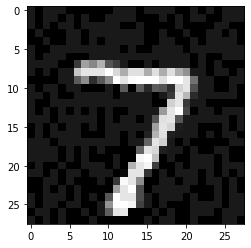

0.215


In [43]:
imshow(fgsm(model, X, y, eps), 0)
print(accuracy(model, fgsm(model, X, y, eps), y))

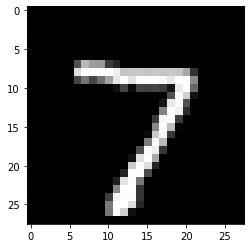

0.985


In [44]:
imshow(fgsm(model, X, y, alpha), 0)
print(accuracy(model, fgsm(model, X, y, alpha), y))

### Testcase 2

Let's see the efficiency of gradient maker in producing a simple one-step universal attack

In [45]:
def univ_1(model, X, y, eps=0.1):
    X_grad = dX(model, X, y).cpu().detach().numpy().reshape(X.shape[0], -1)
    onegrad = torch.from_numpy(gradient_maker(X_grad)).view(X.shape[1:]).to(device)
    X_advs = adv_clip(X + eps * torch.sign(onegrad), X, eps)
    return X_advs.type(torch.FloatTensor).to(device)

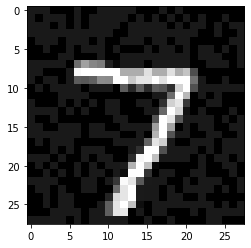

0.885


In [46]:
imshow(univ_1(model, X, y, eps), 0)
print(accuracy(model, univ_1(model, X, y, eps), y))

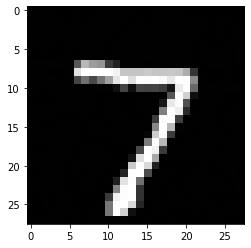

0.995


In [47]:
imshow(univ_1(model, X, y, alpha), 0)
print(accuracy(model, univ_1(model, X, y, alpha), y))

Now, let's compare this with using simple fgsm as universal attack over the batch

In [48]:
accs = []
for i in tqdm(range(X.shape[0])):
    onegrad = torch.sign(dX(model, X, y))[i]
    X_ = adv_clip(X + eps * onegrad, X, eps)
    accs.append(accuracy(model, X_, y))
np.mean(accs)

  0%|          | 0/200 [00:00<?, ?it/s]

0.845

### Testcase 3

In [49]:
def univ_2(model, X, y):
    print(steps, eps, alpha, steps*alpha)
    for step in tqdm(range(steps)):
        X_grad = dX(model, X, y).cpu().detach().numpy().reshape(X.shape[0], -1)
        onegrad = torch.from_numpy(gradient_maker(X_grad)).view(X.shape[1:]).to(device)
        X_advs = adv_clip(X + alpha * torch.sign(onegrad), X, eps).type(torch.FloatTensor).to(device)
        X = Variable(X_advs.data, requires_grad=False)

        #
        gc_collect(X_advs, X_grad)
        empty_cache()
    return X

20 0.1 0.006666666666666667 0.13333333333333333


  0%|          | 0/20 [00:00<?, ?it/s]

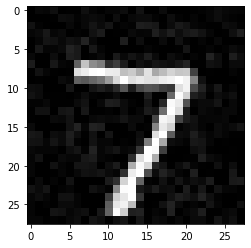

0.96


In [50]:
X_ = univ_2(model, X, y)
imshow(X_, 0)
print(accuracy(model, X_, y))

In [54]:
X_grad = dX(model, X, y).cpu().detach().numpy().reshape(X.shape[0], -1)
print(X_grad.shape)

(200, 784)


In [78]:
X_grad = np.random.randn(200, 784)

In [79]:
onegrad = gradient_maker(X_grad)
print(onegrad.shape)

(784,)


In [80]:
print(np.min(X_grad@onegrad), np.max(X_grad@onegrad))

0.9999999999999956 1.0000000000000049


In [ ]:
def fake_gradient_maker(grads):
    return grads[0]

def log_essentials(grads):
    #
    eps = np.finfo(np.linalg.norm(grads).dtype).eps
    TOLERANCE = max(eps * np.array(grads.shape))

    #
    U, s, V = np.linalg.svd(grads)
    
    #
    print(f"Tolerance={TOLERANCE}, Norm of Sing={np.linalg.norm(s)/s.size}, Rank={np.sum(s > TOLERANCE)}, Rank with 1e-14={np.sum(s > 1e-14)}")

    x = np.linalg.lstsq(X_grad[:-1].T, X_grad[-1].T, None)

In [81]:
A = X_grad
eps = np.finfo(np.linalg.norm(A).dtype).eps
TOLERANCE = max(eps * np.array(A.shape))

U, s, V = np.linalg.svd(A)
print(s)
print(TOLERANCE)
print(np.sum(s > TOLERANCE))

TOLERANCE = 1e-14
print(np.sum(s > TOLERANCE))

[41.84505839 41.67203426 40.90564275 40.72406368 40.43931766 40.21278974
 39.91943319 39.70570761 39.47157684 39.36646066 39.34398525 39.12689861
 38.92511861 38.63062535 38.35638945 38.22812875 37.93062531 37.82991013
 37.64834751 37.39468663 37.23687588 37.08612348 36.79903253 36.63589854
 36.45318115 36.33395838 35.9641412  35.88010548 35.74159517 35.66646942
 35.49197377 35.48111619 35.27815912 35.02651752 34.94131487 34.80073657
 34.49323265 34.42682372 34.33473242 34.28188776 34.24800955 34.18177806
 33.97479005 33.82253281 33.71734336 33.62595669 33.47165905 33.36843684
 33.30838887 33.06125056 32.78665206 32.71366107 32.65911249 32.39033859
 32.32065321 32.17518114 32.06890941 31.97609988 31.9182094  31.71997505
 31.64175427 31.47534883 31.19108922 31.07910851 30.89744051 30.85875272
 30.78680541 30.66567853 30.47059427 30.36866963 30.24845263 30.04987129
 30.02330027 29.92966945 29.80483683 29.70016051 29.56127091 29.54284888
 29.34089979 29.29932845 29.13756138 29.07054442 28

In [82]:
x = np.linalg.lstsq(X_grad[:-1].T, X_grad[-1].T, None)

In [83]:
np.linalg.norm((X_grad[:-1].T@x[0])-X_grad[-1])**2

638.1228515053233

In [84]:
x[1]

array([638.12285151])